In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json, os
from dotenv import load_dotenv
from OddsJamClient import OddsJamClient
from db_utils import get_db
from models import OddsJam, OddsPortal
from models import ALL_SPORTSBOOKS
from sports import *
from datetime import datetime, timedelta
from models import OddsRecord
from tqdm import tqdm_notebook
load_dotenv()
import requests
oj = OddsJam(api_key=os.getenv("ODDSJAM_API_KEY"))
from models import OddsPortal, Game, Market, Team

## Initialize webdriver 

In [20]:
op = OddsPortal(headless=True)
op.driver.get("https://www.oddsportal.com")
cookies = pd.read_csv("./models/sportsbooks/odds_portal_cookies.tsv", sep="	")[["name","value", "domain"]].to_dict(orient="records")
[op.driver.add_cookie(cookie_dict=c) for c in cookies]
start_year=2022


## Get game links by year

In [ ]:

# all_games = []
# for start_year in range(2008, 2022):
#     games = op.get_games_by_year(start_year=start_year)
#     # pd.DataFrame.from_records([dict(g) for g in games]).to_csv(f"./data/NBA/games/{start_year}-{start_year+1}-games.csv")
#     all_games.extend(games)
# pd.DataFrame.from_records([vars(g) for g in all_games]).to_csv(f"./data/NBA/games/all-games.csv")



## Get game odds by bookie

In [ ]:
# import bson
# games_df = pd.read_csv("./data/NBA/games/all-games.csv", dtype='string', keep_default_na=False).sort_values(by="start_timestamp")

# games_df['teams'] = games_df['teams'].apply(lambda x: json.loads(x.replace("\'", "\"")))
# games_df['scores'] = games_df['scores'].apply(lambda x: json.loads(x.replace("\'", "\"")))
# games_df['metadata'] = games_df['metadata'].apply(lambda x: json.loads(x.replace("\'", "\"")))
# games_df = games_df.rename(columns={"id": "_id"})


# markets_df = pd.DataFrame()
# markets_df['_id'] = [str(bson.ObjectId()) for _ in range(len(games_df))]
# markets_df['market_name'] = "moneyline"
# markets_df['lines'] = games_df['teams'].apply(lambda x: [e + " to win" for e in x])
# markets_df['winning_line'] =  games_df['scores'].apply(lambda x: max(x, key=x.get) + " to win")
# games_df['markets'] = [[m] for m in markets_df.to_dict("records")]
# games_df.to_json("./data/NBA/games/all-games.json", "records")

In [2]:
games = Game.games_from_json('./data/NBA/games/all-games.json')
print(len(games))
odds_records = []
batch_number = 2
start_game = [g for g in games if g.metadata["url"] == "/basketball/usa/nba-2020-2021/denver-nuggets-cleveland-cavaliers-MLo9FlAM/"][0]
sorted_games = sorted(games, key=lambda x: x.start_timestamp, reverse=True)
for game in tqdm_notebook(sorted_games[sorted_games.index(start_game):]):
    try:
        odds_records.extend(op.get_game_odds(game))
    except Exception as e:
        print(e)
with open(f"./data/NBA/odds/all-odds-moneyline-{batch_number}.json", "w") as f:
    json.dump([json.loads(o.model_dump_json(by_alias=True)) for o in odds_records], f)


18930


/var/folders/6b/t83jzcrj3zj728qckvy4kj300000gn/T/ipykernel_82425/1351310456.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for game in tqdm_notebook(sorted_games[sorted_games.index(start_game):]):


  0%|          | 0/16734 [00:00<?, ?it/s]

Message: 
Stacktrace:
0   chromedriver                        0x0000000100cfe004 chromedriver + 4169732
1   chromedriver                        0x0000000100cf5ff8 chromedriver + 4136952
2   chromedriver                        0x000000010094b500 chromedriver + 292096
3   chromedriver                        0x00000001009907a0 chromedriver + 575392
4   chromedriver                        0x00000001009cb818 chromedriver + 817176
5   chromedriver                        0x00000001009845e8 chromedriver + 525800
6   chromedriver                        0x00000001009854b8 chromedriver + 529592
7   chromedriver                        0x0000000100cc4334 chromedriver + 3932980
8   chromedriver                        0x0000000100cc8970 chromedriver + 3950960
9   chromedriver                        0x0000000100cac774 chromedriver + 3835764
10  chromedriver                        0x0000000100cc9478 chromedriver + 3953784
11  chromedriver                        0x0000000100c9eab4 chromedriver + 3779252

In [24]:
records = oj.get_current_odds(game.game_id, "Moneyline", sportsbooks=ALL_SPORTSBOOKS)

In [30]:
# convert odds to implied probs
from utils import american_odds_to_probability
from collections import defaultdict
# map from marketsids to odds
games = Game.games_from_json("./data/NBA/games/all-games.json")
odds_records = OddsRecord.odds_from_json("./data/NBA/odds/all-odds-moneyline-1.json")
odds_records = [o for  o in odds_records if o.prices]
market_odds_map = defaultdict(list)

for o in odds_records:
    o.prices =  {bookie: american_odds_to_probability(price) for bookie, price in o.prices.items()}
    market_odds_map[str(o.market_id)].append(o)
    o.prices["average"] = sum(o.prices.values())/len(o.prices)
    
# list of (game, [oddsRecords])
games_with_odds = [(g, market_odds_map[str(g.markets[0].id)]) for g in games if str(g.markets[0].id) in market_odds_map]

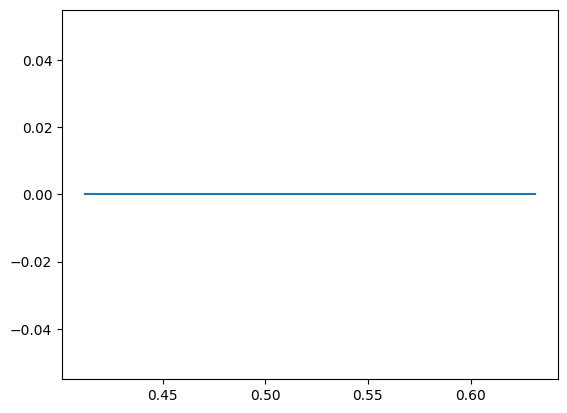

In [34]:
# plot bookmaker average odds vs. game outcome
for g, o in games_with_odds:
    bookie_avg_odds = []
    game_outcomes = []
    for o_r in o:
        if g.markets[0].winning_line == o_r.line_name:
            game_outcomes.append(1)
        else:
            game_outcomes.append(0)
        bookie_avg_odds.append(o_r.prices["average"])
plt.plot(bookie_avg_odds, game_outcomes)

In [48]:
games_with_odds[4][0].markets[0].winning_line

'Indiana Pacers to win'

In [11]:
import json
with open("./test.json", "r") as f:
    data = json.load(f)


In [10]:
data["d"].keys()

dict_keys(['bt', 'sc', 'nav', 'oddsdata', 'history', 'time-base', 'brokenParser', 'encodeventId', 'live-stream'])

In [27]:
data["d"]["nav"]

{'1': {'2': ['451',
   '27',
   '581',
   '381',
   '641',
   '43',
   '46',
   '164',
   '141',
   '417',
   '550',
   '3',
   '129',
   '33',
   '470',
   '165',
   '584',
   '638',
   '617',
   '392',
   '53',
   '24',
   '139'],
  '3': ['451', '381', '550', '470', '417'],
  '4': ['417', '470', '550', '381'],
  '8': ['451', '581', '617', '584', '381', '638', '550', '470', '641', '417'],
  '9': ['451', '141', '381', '550', '470', '417'],
  '10': ['451', '141', '381', '550', '470', '417'],
  '11': ['470', '451', '550']},
 '2': {'1': ['406',
   '33',
   '550',
   '129',
   '147',
   '417',
   '26',
   '575',
   '381',
   '15',
   '43',
   '641',
   '419',
   '372',
   '24',
   '470',
   '157',
   '638',
   '617',
   '18',
   '392',
   '53',
   '16',
   '584',
   '5',
   '581'],
  '2': ['470', '27', '139'],
  '3': ['470',
   '641',
   '381',
   '417',
   '575',
   '581',
   '27',
   '550',
   '638',
   '18',
   '584',
   '617'],
  '4': ['417', '381'],
  '8': ['638', '617', '584', '581',

In [23]:
data["d"]["oddsdata"]

{'back': {'E-3-1-0-0-0': {'handicapTypeId': 0,
   'handicapValue': 0,
   'mixedParameterId': 0,
   'mixedParameterName': None,
   'isBack': True,
   'outcomeId': ['6l11ix2rrhkx0xhqahn', '6l11ix2rrhkx0xhqaho'],
   'odds': {'3': [3.6, 1.31],
    '5': [3.75, 1.29],
    '15': [3.7, 1.29],
    '16': [3.65, 1.3],
    '18': [3.86, 1.3],
    '21': [3.75, 1.29],
    '24': [3.7, 1.29],
    '26': [3.6, 1.3],
    '27': [3.6, 1.29],
    '33': [3.7, 1.29],
    '43': [3.7, 1.29],
    '44': [3.55, 1.3],
    '46': [2.9, 1.38],
    '53': [3.6, 1.3],
    '76': [2.85, 1.36],
    '129': [2.95, 1.2],
    '139': [3.5, 1.27],
    '141': [3.52, 1.26],
    '147': [3.5, 1.3],
    '157': [3.65, 1.29],
    '164': [2.9, 1.38],
    '165': [3, 1.4],
    '372': [3.7, 1.29],
    '381': [3.74, 1.3],
    '390': [3.55, 1.31],
    '392': [3.6, 1.3],
    '406': [3.6, 1.3],
    '417': [3.82, 1.33],
    '419': [3.65, 1.3],
    '429': [3.5, 1.29],
    '470': [3.7, 1.3],
    '550': [3.54, 1.29],
    '575': [3.86, 1.29],
    '58

In [8]:
data["refresh"]

20

In [47]:
event = "1-3-ALE84mei-3-1-yj42a.dat"

In [ ]:
import requests

cookies = {
    'op_user_logout': '0',
    '_ga_5YY4JY41P1': 'GS1.1.1699589640.4.1.1699589766.60.0.0',
    '_sg_b_v': '8%3B68039%3B1699589641',
    'OptanonConsent': 'isGpcEnabled=0&datestamp=Thu+Nov+09+2023+20%3A14%3A57+GMT-0800+(Pacific+Standard+Time)&version=202309.1.0&browserGpcFlag=0&isIABGlobal=false&hosts=&consentId=265c2db0-d4f9-496e-8b12-ecbd04f5ec06&interactionCount=2&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0004%3A1%2CBG114%3A1&AwaitingReconsent=false&geolocation=US%3BCA',
    '_ga': 'GA1.1.1175153109.1699519884',
    'XSRF-TOKEN': 'eyJpdiI6ImJEaW42K0JyTEx2Wk9BeG9jZUQzTGc9PSIsInZhbHVlIjoiT2RWN1h3VXBJSTgvU3d3YWl5dlVTM0ZxaENZM3RiNk1RVWdXVzRSOUowaEp1RURwSmNPNnN2KzJJdndQbjZLeThLbzU4REpEWFdsOU1OMytNTlc3MXBrTWlJVVZhQzFEUmRMSVdmbDdUU0hKdU83aGc4QzNBM2JNMTFzUDk4L3YiLCJtYWMiOiIyYmRjOTAyZGU4MzMxNDYwODQxNDllOTMwZTMxNDE4ZmQ0MWM5N2YwMDM5ZDhjNjRiZDE2ZWMyMjM0OWY0N2ZhIiwidGFnIjoiIn0%3D',
    '_sg_b_p': '%2Fbasketball%2Fusa%2Fnba-2022-2023%2Fresults%2F%2C%2Fbasketball%2Fusa%2Fnba-2020-2021%2Fresults%2F%2C%2Fbasketball%2Fusa%2Fnba-2020-2021%2Fmilwaukee-bucks-phoenix-suns-ULD28jPK%2F%2C%2Fbasketball%2Fusa%2Fnba-2021-2022%2Fresults%2F%2C%2Fbasketball%2Fusa%2Fnba-2021-2022%2Fboston-celtics-golden-state-warriors-j3bM4Y8o%2F',
    'oddsportalcom_session': 'eyJpdiI6Ik45VXFGZ1grS1NXb0F4QzE2bDFRaGc9PSIsInZhbHVlIjoiQTc4NWQ2UjNIT2hUU3daYThCU3YxQ09PVUxDdktUOERBeUhheUVIU0dBd0VsaFNwdkdnRm0wU0Q1WC8vZmZmRjh3bW1tc202eTdrVlk2M1NXMjhncWFWa0ErQW1SRThYRXdXYUZDRjFUcll6Zjl3aVNNUlhtbW1pMlN0SmRhTVkiLCJtYWMiOiIxN2ZhYmQxNjhlYzI4M2QzMjUwNzkwNWMyZTRjMGFlNDQ5OWU4M2I0ODBkYmUwYzA5MGU2NDUwMTk4OGYzYTg2IiwidGFnIjoiIn0%3D',
    'op_user_cookie': '6515016553',
    'op_user_hash': 'e9bb1614178fb08bad6e9160faac8e7f',
    'op_user_time': '1699583061',
    'op_user_full_time_zone': '5',
    'op_user_login_hash': 'c7b1e093a493457f240e0cafb9ee3ad4',
    'op_user_login_id': '462563',
    'op_user_time_zone': '-8',
    'remember_web_59ba36addc2b2f9401580f014c7f58ea4e30989d': 'eyJpdiI6IjVDSmhyTjhFWlVFVnBEamcyeUV3U3c9PSIsInZhbHVlIjoia1dZd2xMUWlhZGtwR3FrckNRWC8yaEIvbDBkemZVRFRtTE5YVmVFaXVpOXdVTGdQMnpmcmJXT1JpeE5mVXVJN043NXpGb1NzS1duY2VHa0w5d3pkalhzSWpUUkhVanZIWk5xT3RldDBlTzFsVHMvZkh3KzhZWHlnakZzcU9zZXFTRENFdWRWUU12RHo3TzZrVERHNWRBPT0iLCJtYWMiOiIyZTU4YjZhY2Q5ZTQ0YjI0MjI2NmVkNjE3NDhlMDM4NzcwZmZiYzNmNTAxNThlNjljY2ZmOWYzMjJiYmQ2NzM3IiwidGFnIjoiIn0%3D',
    'OptanonAlertBoxClosed': '2023-11-10T01:05:20.005Z',
    '_sg_b_n': '1699519884977',
    'op_cookie-test': 'ok',
}

headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json, text/plain, */*',
    'Sec-Fetch-Site': 'same-origin',
    'Accept-Language': 'en-US,en;q=0.9',
    # 'Accept-Encoding': 'gzip, deflate, br',
    'Sec-Fetch-Mode': 'cors',
    'Host': 'www.oddsportal.com',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.1 Safari/605.1.15',
    'Referer': 'https://www.oddsportal.com/basketball/usa/nba-2021-2022/results/',
    'Connection': 'keep-alive',
    'Sec-Fetch-Dest': 'empty',
    # 'Cookie': 'op_user_logout=0; _ga_5YY4JY41P1=GS1.1.1699589640.4.1.1699589766.60.0.0; _sg_b_v=8%3B68039%3B1699589641; OptanonConsent=isGpcEnabled=0&datestamp=Thu+Nov+09+2023+20%3A14%3A57+GMT-0800+(Pacific+Standard+Time)&version=202309.1.0&browserGpcFlag=0&isIABGlobal=false&hosts=&consentId=265c2db0-d4f9-496e-8b12-ecbd04f5ec06&interactionCount=2&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0004%3A1%2CBG114%3A1&AwaitingReconsent=false&geolocation=US%3BCA; _ga=GA1.1.1175153109.1699519884; XSRF-TOKEN=eyJpdiI6ImJEaW42K0JyTEx2Wk9BeG9jZUQzTGc9PSIsInZhbHVlIjoiT2RWN1h3VXBJSTgvU3d3YWl5dlVTM0ZxaENZM3RiNk1RVWdXVzRSOUowaEp1RURwSmNPNnN2KzJJdndQbjZLeThLbzU4REpEWFdsOU1OMytNTlc3MXBrTWlJVVZhQzFEUmRMSVdmbDdUU0hKdU83aGc4QzNBM2JNMTFzUDk4L3YiLCJtYWMiOiIyYmRjOTAyZGU4MzMxNDYwODQxNDllOTMwZTMxNDE4ZmQ0MWM5N2YwMDM5ZDhjNjRiZDE2ZWMyMjM0OWY0N2ZhIiwidGFnIjoiIn0%3D; _sg_b_p=%2Fbasketball%2Fusa%2Fnba-2022-2023%2Fresults%2F%2C%2Fbasketball%2Fusa%2Fnba-2020-2021%2Fresults%2F%2C%2Fbasketball%2Fusa%2Fnba-2020-2021%2Fmilwaukee-bucks-phoenix-suns-ULD28jPK%2F%2C%2Fbasketball%2Fusa%2Fnba-2021-2022%2Fresults%2F%2C%2Fbasketball%2Fusa%2Fnba-2021-2022%2Fboston-celtics-golden-state-warriors-j3bM4Y8o%2F; oddsportalcom_session=eyJpdiI6Ik45VXFGZ1grS1NXb0F4QzE2bDFRaGc9PSIsInZhbHVlIjoiQTc4NWQ2UjNIT2hUU3daYThCU3YxQ09PVUxDdktUOERBeUhheUVIU0dBd0VsaFNwdkdnRm0wU0Q1WC8vZmZmRjh3bW1tc202eTdrVlk2M1NXMjhncWFWa0ErQW1SRThYRXdXYUZDRjFUcll6Zjl3aVNNUlhtbW1pMlN0SmRhTVkiLCJtYWMiOiIxN2ZhYmQxNjhlYzI4M2QzMjUwNzkwNWMyZTRjMGFlNDQ5OWU4M2I0ODBkYmUwYzA5MGU2NDUwMTk4OGYzYTg2IiwidGFnIjoiIn0%3D; op_user_cookie=6515016553; op_user_hash=e9bb1614178fb08bad6e9160faac8e7f; op_user_time=1699583061; op_user_full_time_zone=5; op_user_login_hash=c7b1e093a493457f240e0cafb9ee3ad4; op_user_login_id=462563; op_user_time_zone=-8; remember_web_59ba36addc2b2f9401580f014c7f58ea4e30989d=eyJpdiI6IjVDSmhyTjhFWlVFVnBEamcyeUV3U3c9PSIsInZhbHVlIjoia1dZd2xMUWlhZGtwR3FrckNRWC8yaEIvbDBkemZVRFRtTE5YVmVFaXVpOXdVTGdQMnpmcmJXT1JpeE5mVXVJN043NXpGb1NzS1duY2VHa0w5d3pkalhzSWpUUkhVanZIWk5xT3RldDBlTzFsVHMvZkh3KzhZWHlnakZzcU9zZXFTRENFdWRWUU12RHo3TzZrVERHNWRBPT0iLCJtYWMiOiIyZTU4YjZhY2Q5ZTQ0YjI0MjI2NmVkNjE3NDhlMDM4NzcwZmZiYzNmNTAxNThlNjljY2ZmOWYzMjJiYmQ2NzM3IiwidGFnIjoiIn0%3D; OptanonAlertBoxClosed=2023-11-10T01:05:20.005Z; _sg_b_n=1699519884977; op_cookie-test=ok',
    'X-Requested-With': 'XMLHttpRequest',
    'X-XSRF-TOKEN': 'eyJpdiI6ImJEaW42K0JyTEx2Wk9BeG9jZUQzTGc9PSIsInZhbHVlIjoiT2RWN1h3VXBJSTgvU3d3YWl5dlVTM0ZxaENZM3RiNk1RVWdXVzRSOUowaEp1RURwSmNPNnN2KzJJdndQbjZLeThLbzU4REpEWFdsOU1OMytNTlc3MXBrTWlJVVZhQzFEUmRMSVdmbDdUU0hKdU83aGc4QzNBM2JNMTFzUDk4L3YiLCJtYWMiOiIyYmRjOTAyZGU4MzMxNDYwODQxNDllOTMwZTMxNDE4ZmQ0MWM5N2YwMDM5ZDhjNjRiZDE2ZWMyMjM0OWY0N2ZhIiwidGFnIjoiIn0=',
}

params = {
    '_': '1699589768425',
}

response = requests.get(
    'https://www.oddsportal.com/ajax-sport-country-tournament-archive_/3/tpisHrh3/X220577834X24584X65536X0X134217728X0X0X0X0X0X0X0X10485760X134217729X512X1048578X0X0X1024X18464X131584X2304/1/0/',
    params=params,
    cookies=cookies,
    headers=headers,
)

In [1]:
from sportsbooks import OddsPortal

In [2]:
op = OddsPortal()

In [3]:
links = op.get_game_links_by_year(start_year=2021)
op.driver.close()